In [1]:
%load_ext autoreload
%autoreload 2
    
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import time
import pandas as pd
import numpy as np
import os
import time
import re
import pyBigWig
import numpy as np
import pandas as pd
from concurrent.futures import *
from tqdm.auto import *
import pickle

# HepG2 downsampling experiment

In [61]:
frags = pd.read_csv("/data/rzhang/PRINT_rev/HepG2/all.frags.filt.rmbc.tsv.gz", sep='\t', header=None)
frags

,0,1,2,3,4
0,chr1,10067,10108,HepG2,1
1,chr1,10072,10407,HepG2,1
2,chr1,10073,10108,HepG2,1
3,chr1,10073,10119,HepG2,1
4,chr1,10079,10151,HepG2,1
...,...,...,...,...,...
65404904,chrX,156030274,156030298,HepG2,1
65404905,chrX,156030596,156030620,HepG2,1
65404906,chrX,156030596,156030620,HepG2,1
65404907,chrX,156030596,156030628,HepG2,1


In [62]:
frag_num_list = [50000000, 25000000, 10000000, 5000000, 2500000, 1000000]
frag_num_list = [2500000]

In [63]:
for frag_num in frag_num_list:
    frags_filt = frags.sample(frag_num)
    frags_filt.to_csv(f"/data/rzhang/PRINT_rev/HepG2/frags.filt.rmbc.{frag_num}.tsv.gz", sep='\t', header=False, index=False)

In [64]:
printer_dict = {}
for frag_num in frag_num_list:
    h5ad_path = f"/data/rzhang/PRINT_rev/HepG2/HepG2_{frag_num}.h5ad"
    if not os.path.exists(h5ad_path):
        printer_dict[frag_num] = scp.pp.import_fragments(
                        pathToFrags= f"/data/rzhang/PRINT_rev/HepG2/frags.filt.rmbc.{frag_num}.tsv.gz",
                        barcodes=None,
                        savename=h5ad_path,
                        genome=scp.genome.hg38,
                        min_num_fragments=0, min_tsse=0,
                        sorted_by_barcode=False, 
                        low_memory=False,
                        )
    else:
        printer_dict[frag_num] = scp.load_printer(h5ad_path, scp.genome.hg38)

You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False
detected plus_shift and minus_shift are 4 -5
snapatac2 shift check True
Initializing GFF-db


In [65]:
for frag_num in frag_num_list:
    printer = printer_dict[frag_num]
    scp.pp.sync_footprints(printer,
                       printer.insertion_file.obs_names,
                       f"HepG2_{frag_num}")
    

Insertion profile from csr to csc
Creating bigwig for HepG2_2500000


  0%|          | 0/24 [00:00<?, ?it/s]

In [66]:
for frag_num in frag_num_list:
    scp.peak.macs2(f"/data/rzhang/PRINT_rev/HepG2/frags.filt.rmbc.{frag_num}.tsv.gz",
                   'macs2_encode', 
                   f'/data/rzhang/PRINT_rev/HepG2/peak_call_{frag_num}')
    cleaned_peaks = scp.peak.clean_macs2('macs2_encode', f'/data/rzhang/PRINT_rev/HepG2/peak_call_{frag_num}',
                peak_width=128,
                blacklist_peak_width=1000,
                genome=scp.genome.hg38, filter_chr=False,
                n=999999999, fdr_threshold=0.01, use_quantile_scores=False, final_peak_width=1000
                )
    cleaned_peaks.to_csv(f'/data/rzhang/PRINT_rev/HepG2/HepG2_{frag_num}_cleaned_narrowPeak.bed', 
                         sep='\t', header=False, index=False)

INFO  @ Wed, 13 Mar 2024 06:39:19: 
# Command line: callpeak --nomodel -t /data/rzhang/PRINT_rev/HepG2/frags.filt.rmbc.2500000.tsv.gz --outdir /data/rzhang/PRINT_rev/HepG2/peak_call_2500000 -n macs2_encode -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150
# ARGUMENTS LIST:
# name = macs2_encode
# format = BEDPE
# ChIP-seq file = ['/data/rzhang/PRINT_rev/HepG2/frags.filt.rmbc.2500000.tsv.gz']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is on
# Searching for subpeak summits is on
# MACS will save fragment pileup signal per million reads
 
INFO  

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..



INFO  @ Wed, 13 Mar 2024 06:39:37: #4 Write summits bed file... /data/rzhang/PRINT_rev/HepG2/peak_call_2500000/macs2_encode_summits.bed 
INFO  @ Wed, 13 Mar 2024 06:39:37: Done! 


  0%|          | 0/1 [00:00<?, ?it/s]

/home/rzhang/miniforge3/envs/scprinter/lib/python3.10/site-packages/bioframe/ops.py:1622: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trimmed[sk].clip(lower=lower_vector, upper=upper_vector, inplace=True)
/home/rzhang/miniforge3/envs/scprinter/lib/python3.10/site-packages/bioframe/ops.py:1623: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o

Filtering overlapping peaks based on peak summit score ..
round: 1 53511 peaks unresolved 53373 peaks selected
round: 2 4 peaks unresolved 4 peaks selected
finish clearing
finish sorting
finished summary


In [67]:
from scprinter.seq.dataloader import hg38_splits
import json
for frag_num in frag_num_list:
    for fold in [0,1,2,3,4]:
        default_config = {
          "peaks": f"HepG2_{frag_num}_cleaned_narrowPeak.bed",
          "signals": f"HepG2_{frag_num}.bw",
          "genome": "hg38",
          "split": hg38_splits[fold],
          "max_jitter": 128,
          "reverse_compliment": True,
          "n_filters": 1024,
          "bottleneck_factor": 1,
          "no_inception": False,
          "groups": 8,
          "n_layers": 8,
          "n_inception_layers": 8,
          "inception_layers_after": True,
          "inception_version": 2,
          "activation": "gelu",
          "batch_norm_momentum": 0.1,
          "dilation_base": 1,
          "rezero": False,
          "batch_norm": True,
          "batch_size": 64,
          "head_kernel_size": 1,
          "kernel_size": 3,
          "weight_decay": 1e-3,
          "lr": 3e-3,
          "scheduler": False,
          "savename": f"HepG2_{frag_num}_fold{fold}",
          "amp": True,
          "ema": True,
          "notes": "v2",
          "tags": ["HepG2", f'{frag_num}',f'fold{fold}']
        }
        json.dump(default_config, open(f'./config_dir/v2/HepG2_{frag_num}_fold{fold}.JSON', 'w'), indent=4)
        
    

In [68]:
for k in printer_dict:
    printer_dict[k].close()

In [69]:
printer.close()

In [87]:
models = ["HepG2_10000000_fold0-prosperous-goat-117.pt",
"HepG2_10000000_fold1-resplendent-orchid-118.pt",
"HepG2_10000000_fold2-prosperous-lamp-116.pt",
"HepG2_10000000_fold3-prosperous-envelope-119.pt",
"HepG2_10000000_fold4-flashing-chrysanthemum-120.pt",
"HepG2_1000000_fold0-fortuitous-chrysanthemum-126.pt",
"HepG2_1000000_fold1-abundant-fish-127.pt",
"HepG2_1000000_fold2-crimson-moon-128.pt",
"HepG2_1000000_fold3-resplendent-chrysanthemum-129.pt",
"HepG2_1000000_fold4-incandescent-goat-129.pt",
"HepG2_25000000_fold0-virtuous-dragon-112.pt",
"HepG2_25000000_fold1-thriving-goat-111.pt",
"HepG2_25000000_fold2-lunar-dog-113.pt",
"HepG2_25000000_fold3-dazzling-pig-115.pt",
"HepG2_25000000_fold4-sparkling-rabbit-114.pt",
"HepG2_50000000_fold0-incandescent-chrysanthemum-106.pt",
"HepG2_50000000_fold1-dancing-lantern-106.pt",
"HepG2_50000000_fold2-radiant-chrysanthemum-106.pt",
"HepG2_50000000_fold3-filigreed-rabbit-110.pt",
"HepG2_50000000_fold4-golden-rocket-109.pt",
"HepG2_5000000_fold0-glittering-goat-122.pt",
"HepG2_5000000_fold1-sparkling-dragon-121.pt",
"HepG2_5000000_fold2-fortuitous-dog-123.pt",
"HepG2_5000000_fold3-vermilion-tiger-124.pt",
"HepG2_5000000_fold4-bright-festival-125.pt"]

In [90]:
commands = [f"python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/{model}  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --overwrite --decay 0.85 &"  for model in models]
for c in commands:
    print (c)

python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold0-prosperous-goat-117.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold1-resplendent-orchid-118.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold2-prosperous-lamp-116.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold3-prosperous-envelope-119.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper count --nth_output 0 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python ev

In [91]:
commands = [f"python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/{model}  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --overwrite --decay 0.85 &"  for model in models]
for c in commands:
    print (c)

python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold0-prosperous-goat-117.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold1-resplendent-orchid-118.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold2-prosperous-lamp-116.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --overwrite --decay 0.85 &
python evaluation_model.py --pt ../PRINT_rev/HepG2/final_model/HepG2_10000000_fold3-prosperous-envelope-119.pt  --peaks ../PRINT_rev/HepG2/peaks.bed  --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 --genome hg38 --overwrite 

# HepG2 downsample evaluate

In [114]:
feats = ['attr.count.shap_hypo_0_.0.85.bigwig',
         'attr.just_sum.shap_hypo_0-30_.0.85.bigwig',
        ]

In [115]:
tsv_paths = {
    'HepG2_50M': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_25M': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_10M': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_5M': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_2.5M': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_1M': "/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
    'HepG2_full':"/data/rzhang/PRINT_rev/HepG2/TF_prediction.tsv",
}
peaks_path = {
    'HepG2_50M': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_25M': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_10M': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_5M': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_2.5M': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_1M': "/data/rzhang/PRINT_rev/HepG2/peaks.bed",
    'HepG2_full':"/data/rzhang/PRINT_rev/HepG2/peaks.bed"
}

model_name = {
    'HepG2_50M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold0-incandescent-chrysanthemum-106.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold1-dancing-lantern-106.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold2-radiant-chrysanthemum-106.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold3-filigreed-rabbit-110.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold4-golden-rocket-109.pt_deepshap",],
    'HepG2_25M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold0-virtuous-dragon-112.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold1-thriving-goat-111.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold2-lunar-dog-113.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold3-dazzling-pig-115.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold4-sparkling-rabbit-114.pt_deepshap",],
    'HepG2_10M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold0-prosperous-goat-117.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold1-resplendent-orchid-118.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold2-prosperous-lamp-116.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold3-prosperous-envelope-119.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold4-flashing-chrysanthemum-120.pt_deepshap",],
    'HepG2_5M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold0-glittering-goat-122.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold1-sparkling-dragon-121.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold2-fortuitous-dog-123.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold3-vermilion-tiger-124.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold4-bright-festival-125.pt_deepshap"],
    'HepG2_2.5M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold0-stellar-snowflake-159.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold1-prime-frost-157.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold2-radiant-forest-158.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold3-daily-violet-156.pt_deepshap",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold4-flowing-sun-160.pt_deepshap"],
    'HepG2_1M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold0-fortuitous-chrysanthemum-126.pt_deepshap",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold1-abundant-fish-127.pt_deepshap",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold2-crimson-moon-128.pt_deepshap",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold3-resplendent-chrysanthemum-129.pt_deepshap",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold4-incandescent-goat-129.pt_deepshap",
            ],
    'HepG2_full': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold0-crimson-bao-8.pt_deepshap",
                   "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold1-auspicious-rocket-9.pt_deepshap",
                   "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold2-prosperous-fish-8.pt_deepshap",
                    "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold3-prosperous-bao-11.pt_deepshap",
                    "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold4-radiant-paper-12.pt_deepshap",
                  ]
}


In [11]:

def read_TF_loci(path):
    TF_prediction = pd.read_csv(path, sep='\t')
    if 'range' in TF_prediction.columns:
        ranges = pd.DataFrame([re.split(':|-', xx) for xx in TF_prediction['range']])
        ranges = ranges[[0,1,2,3]]
        v = np.array(ranges[3])
        v[v == ''] = '-'
        ranges[3] = v
        ranges.columns = ['chrom','start','end', 'strand']
        ranges['start'] = ranges['start'].astype('int')
        ranges['end'] = ranges['end'].astype('int')
        TF_prediction = pd.concat([TF_prediction, ranges], axis=1)
    else:
        TF_prediction = pd.read_csv(path, sep='\t', header=None)
        TF_prediction.columns = ['chrom','start','end', 'bound', 'TF']
        TF_prediction['strand'] = '+'
    # TF_prediction = TF_prediction.sort_values(by=['bound'], ascending=False) # sort such that bound = 1, comes first, and will be kept.
    TF_prediction['summit'] = (TF_prediction['start']-1 + TF_prediction['end']) // 2
    # TF_prediction = TF_prediction.drop_duplicates(['chrom','start', 'end'])
    # TF_prediction = TF_prediction[TF_prediction['chrom'].isin(['chr1', 'chr3', 'chr6'])]
    return TF_prediction

def read_peaks(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['chrom', 'start', 'end']
    print (df)
    return df

def get_normalization_factor(model, feat, peak, low=0.05, 
                             median = 0.5,
                             high=0.95, sample_num=30000):
    vs = []
    with pyBigWig.open(f"{model}/{feat}", 'r') as f:
        chroms = f.chroms().keys()
        print (chroms)
        peaks = peak[peak['chrom'].isin(chroms)].copy()
        peaks = peaks.sample(sample_num, replace=True).copy()
        for chrom, start, end in zip(peaks['chrom'], peaks['start'], peaks['end']):
            v = f.values(chrom, int(start), int(end), numpy=True)
            vs.append(v)
            
    vs = np.concatenate(vs)
    vs = np.nan_to_num(vs)
    return np.quantile(vs, low), np.quantile(vs, median), np.quantile(vs, high)
motifs = scp.motifs.Motifs("/data/rzhang/cisBP_human_pwms_2021.jaspar", 
                           scp.genome.hg38.fetch_fa(), scp.genome.hg38.bg)
motif2matrix = {motif.name: np.array([motif.counts['A'], motif.counts['C'], motif.counts['G'], motif.counts['T']]) for motif in motifs.all_motifs}

In [12]:
tsvs = {cell:read_TF_loci(tsv_paths[cell]) for cell in tsv_paths}
peaks = {cell:read_peaks(peaks_path[cell]) for cell in peaks_path}

       chrom      start        end
0       chr1     827026     828026
1       chr1     857897     858897
2       chr1     860538     861538
3       chr1     869441     870441
4       chr1     876235     877235
...      ...        ...        ...
168743  chrX  155196066  155197066
168744  chrX  155215887  155216887
168745  chrX  155264002  155265002
168746  chrX  155293509  155294509
168747  chrX  155612275  155613275

[168748 rows x 3 columns]
       chrom      start        end
0       chr1     827026     828026
1       chr1     857897     858897
2       chr1     860538     861538
3       chr1     869441     870441
4       chr1     876235     877235
...      ...        ...        ...
168743  chrX  155196066  155197066
168744  chrX  155215887  155216887
168745  chrX  155264002  155265002
168746  chrX  155293509  155294509
168747  chrX  155612275  155613275

[168748 rows x 3 columns]
       chrom      start        end
0       chr1     827026     828026
1       chr1     857897     858897
2

In [13]:
from concurrent.futures import *
from tqdm.auto import *
pool= ProcessPoolExecutor(max_workers=100)
norm_factor = {}
p_list = []
for cell in model_name:
    norm_factor[cell] = {}
    for feat in feats:
        norm_factor[cell][feat] = []
        for model in model_name[cell]:
            p = pool.submit(get_normalization_factor,model, 
                                                   feat,
                                                   peaks[cell], sample_num=30000)
            norm_factor[cell][feat].append(p)
            p_list.append(p)
for p in tqdm(as_completed(p_list), total=len(p_list)):
    continue
for cell in model_name:
    for feat in feats:
        for i, model in enumerate(model_name[cell]):
            norm_factor[cell][feat][i] = norm_factor[cell][feat][i].result()
            

  0%|          | 0/70 [00:00<?, ?it/s]

dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX'])
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr

In [14]:
from pyfaidx import Fasta
from scipy.stats import *
def cosine(x,y):
    return (x*y).sum() / (np.linalg.norm(x) * np.linalg.norm(y))
    # return spearmanr(x, y)[0]
def get_feats(model, feat, tsv,
              flank,
              low, median, high, chroms = None,
             verbose=False):
    fasta = Fasta(scp.genome.hg38.fetch_fa())
    signals = []
    similarity = []
    strengths = []
    with pyBigWig.open(f"{model}/{feat}", 'r') as f:
        if chroms is None:
            chroms = f.chroms().keys()
        tsv = tsv[tsv['chrom'].isin(chroms)].copy()
        chrom, summit, strand = np.array(tsv['chrom']), np.array(tsv['summit']), np.array(tsv['strand'])
        starts, ends, strands = np.array(tsv['start']), np.array(tsv['end']), np.array(tsv['strand'])
        tfs = np.array(tsv['TF'])
        labels = np.array(tsv['bound'])

        
        for c,s,sd,tf, start,end in zip(tqdm(chrom, disable=not verbose), summit, strands, tfs, starts, ends):
            
            try:
                v = f.values(c, s-flank, s+flank+1, numpy=True)
            except:
                print (c, s-flank, s+flank+1)
                v = np.zeros((int(2*flank+1)))
            if sd != '+':
                v = v[::-1]

            # seq = hg38.fetch_onehot_seq(c, start-1, end).numpy()
            seq = fasta[c][start-1:end].seq
            seq = scp.utils.DNA_one_hot(seq).numpy()
            seq_trend = f.values(c, start-1, end, numpy=True)
            if sd == '-':
                seq = seq[::-1][:, ::-1]
                seq_trend = seq_trend[::-1]
            motif_trend = (motif2matrix[tf] * seq).sum(axis=0)
            motif_match = cosine(motif2matrix[tf].reshape((-1)), seq.reshape((-1)))
            
            signals.append(v)
            similarity.append([cosine(seq_trend, motif_trend), 
                               # motif_match,
                               ((seq_trend - median) / (high - low)).mean()])
    
    signals = np.array(signals)
    similarity = np.array(similarity)
    signals = np.nan_to_num(signals)
    similarity =  np.nan_to_num(similarity)

    # for tf in np.unique(tfs):
    #     mask = tfs == tf
    #     v = similarity[mask]
    #     v = (v - np.min(v, axis=0, keepdims=True)) / (np.max(v, axis=0, keepdims=True) - np.min(v, axis=0, keepdims=True))
    #     similarity[mask] = v

    
    signals = (signals - median) / (high - low)
    return signals, similarity, tsv

In [15]:
feats_all = {}
labels_all = {}
pool= ProcessPoolExecutor(max_workers=200)
p_list = []
for cell in model_name:
    for feat in feats:
        for i, model in enumerate(model_name[cell]):
            lo, mid, hi = norm_factor[cell][feat][i]
            p_list.append(pool.submit(get_feats,model, feat, tsvs[cell], 
                  100,
                  lo, mid, hi))

for p in tqdm(as_completed(p_list), total=len(p_list)):
    continue
ct = 0
for cell in model_name:
    feats_cell = []
    sims_cell = []
    for feat in feats:
        feats_v = 0
        sims_v = 0
        for i, model in enumerate(model_name[cell]):
            feats_, sims_, labels = p_list[ct].result()
            ct += 1
            feats_v += feats_
            sims_v += sims_
        feats_v = feats_v / len(model_name[cell])
        sims_v = sims_v / len(model_name[cell])
        feats_cell.append(feats_v)
        sims_cell.append(sims_v)
    feats_cell = np.stack(feats_cell, axis=1)
    sims_cell = np.stack(sims_cell, axis=1)
    # print (feats_cell.shape, sims_cell.shape)
    feats_all[cell] = [feats_cell, sims_cell]
    labels_all[cell] = labels
pool.shutdown(wait=True)

  0%|          | 0/70 [00:00<?, ?it/s]

In [16]:
def feats_for_cell(feats_all, labels_all, cell, window=201, n_feats=np.arange(8)):
    seq_attr = feats_all[cell][0]
    pad = (seq_attr.shape[-1] - window) // 2
    if pad > 0:
        seq_attr = seq_attr[..., pad:-pad]
    # seq_attr = seq_attr[:, n_feats].reshape((len(seq_attr), -1))
    seq_motif_sim = feats_all[cell][1][:, n_feats]
    motifs = np.asarray(labels_all[cell]['motifMatchScore'])[:, None]
    motifs = np.stack([motifs] * len(n_feats), axis=1)
    # feats = seq_motif_sim.reshape((len(seq_attr), -1))
    feats = np.concatenate([motifs, seq_motif_sim, seq_attr], axis=-1)
    print (motifs.shape, seq_motif_sim.shape, seq_attr.shape)
    return feats

In [17]:
import pickle
scaler = pickle.load(open("TFBS_scaler_GM.pkl", "rb"))

In [18]:
def eval_model(feats_all, labels_all, 
               clf_mega, 
               cell, 
               window=201, 
               n_feats=3, 
               feat_mask = None, 
               scaler=None):
    from sklearn.metrics import average_precision_score
    feats = feats_for_cell(feats_all, 
                                           labels_all, 
                                           cell, 
                                           window=window, 
                                           n_feats=np.arange(n_feats))
    tsv = labels_all[cell]
    shape = feats.shape
    print (feats.shape)
    print (feats[:, :, 1].min(), feats[:, :, 1].max())
    feats = feats.reshape((len(feats), -1))
    
    if scaler is not None:
        if type(scaler) is tuple:
            feats = (feats - scaler[0]) / scaler[1]
            feats = feats.reshape(shape)
        else:
            feats = scaler.transform(feats).reshape(shape)
        # feats[:, :, 1] =  0
        # feats[:, :, 2:] =  0
   
    pred_all = 0
    for i, model in enumerate(clf_mega):
        pred = torch.sigmoid(model(torch.from_numpy(feats)[:, i, :].float())).detach().cpu().numpy()
        # pred = feats[:, :, 1]
        pred_all += pred
        tsv[f'pred_{i}'] = pred
    pred_all /= len(clf_mega)
    # pred_all = torch.sigmoid(clf_mega[0](torch.from_numpy(feats)[:, :2, :].float())).detach().cpu().numpy()
    tsv['pred'] = pred_all
    return tsv
    
def summarize(tsv, col='pred'):
    from sklearn.metrics import average_precision_score
    sig = tsv.copy()
    score1 = average_precision_score(sig['bound'], sig[col])
    summary = sig.groupby('TF')

    precisions = []
    auprs = []
    tfs = []
    for tf, sig in summary:
        v = np.array(sig[col])
        label = np.array(sig['bound'])
        top10pct = np.mean(label[v >= np.quantile(v, 0.9)])
        aupr = average_precision_score(sig['bound'], sig[col])
        precisions.append(top10pct)
        auprs.append(aupr)
        tfs.append(tf)
    summary_performance = pd.DataFrame({'tf':tfs, 'precision': precisions, 'aupr':auprs})
    return score1, summary_performance['precision'].mean(), summary_performance['precision'].median(), summary_performance['aupr'].mean(), summary_performance['aupr'].median()


In [19]:
import torch
models = [torch.jit.load(f"TFBS_GM_{i}.pt", map_location='cpu').eval() for i in range(2)]

In [28]:
scores = []

In [29]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_full',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.9790139842227129 0.9898693072457754
(0.6411333460982448, 0.69732665494949, 0.7155071588269364, 0.619493040210647, 0.6355309522091197)


In [30]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_50M',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.9801533558194103 0.990133403242211
(0.6393485045779159, 0.6961520904491622, 0.7064831133890926, 0.6182327844613571, 0.6340944113954228)


In [31]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_25M',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.9744153076237421 0.9906281838512246
(0.633720854889707, 0.6935908908597663, 0.7081460830777808, 0.6123256249194949, 0.6279340703409053)


In [32]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_10M',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.9727028851808026 0.9919645554518514
(0.6254027153358397, 0.6849153495681012, 0.7030845179372791, 0.6034624476345476, 0.6225671870166158)


In [33]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_5M',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.973418133213045 0.9915251316384117
(0.6056202186959009, 0.662647389709396, 0.6881677331037988, 0.5775220765327227, 0.5935459431095054)


In [34]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_2.5M',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.9714673219432516 0.9882898675349459
(0.5894195454230392, 0.644347601404171, 0.6629702177404099, 0.5609772076338987, 0.5743784688104623)


In [35]:
import pandas as pd
score = eval_model(feats_all, labels_all, models, 'HepG2_1M',201, 2, scaler=(scaler.mean_[:408], scaler.scale_[ :408]))
print (summarize(score,'pred'))
scores.append(summarize(score, 'pred')[2])
# for i in range(8):
#     print (summarize(score,f'pred_{i}'))

(859876, 2, 1) (859876, 2, 2) (859876, 2, 201)
(859876, 2, 204)
-0.9125760777126377 0.9874166490070403
(0.5338004336587968, 0.6000845288166703, 0.6225272229043324, 0.5069935486615232, 0.5072581949711279)


In [37]:
frags = [65.5, 50, 25, 10, 5, 2.5, 1]

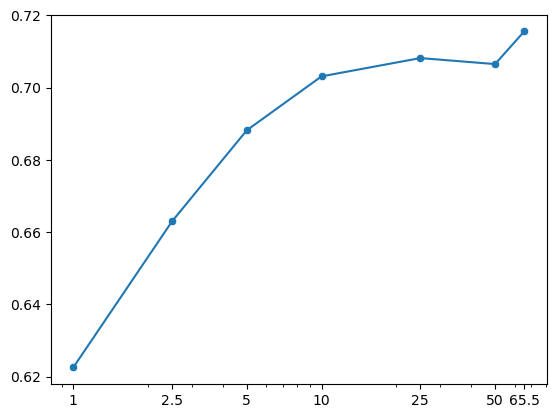

In [47]:
sns.scatterplot(x=frags, y=scores)
ax=sns.lineplot(x=frags, y=scores)
plt.xscale("log")
ax.set_xticks(frags, frags)
plt.savefig('/data/rzhang/PRINT_rev/HepG2/downsample_TFBS_median_precision.pdf')

Now for evaluating predicted footprints vs gt

In [116]:
import torch
torch.cuda.set_device(7)
torch.set_num_threads(4)
model_name = {
    'HepG2_50M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold0-incandescent-chrysanthemum-106.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold1-dancing-lantern-106.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold2-radiant-chrysanthemum-106.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold3-filigreed-rabbit-110.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold4-golden-rocket-109.pt",],
    'HepG2_25M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold0-virtuous-dragon-112.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold1-thriving-goat-111.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold2-lunar-dog-113.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold3-dazzling-pig-115.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold4-sparkling-rabbit-114.pt",],
    'HepG2_10M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold0-prosperous-goat-117.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold1-resplendent-orchid-118.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold2-prosperous-lamp-116.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold3-prosperous-envelope-119.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold4-flashing-chrysanthemum-120.pt",],
    'HepG2_5M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold0-glittering-goat-122.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold1-sparkling-dragon-121.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold2-fortuitous-dog-123.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold3-vermilion-tiger-124.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold4-bright-festival-125.pt"],
    'HepG2_2.5M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold0-stellar-snowflake-159.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold1-prime-frost-157.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold2-radiant-forest-158.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold3-daily-violet-156.pt",
                "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold4-flowing-sun-160.pt"],
    'HepG2_1M': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold0-fortuitous-chrysanthemum-126.pt",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold1-abundant-fish-127.pt",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold2-crimson-moon-128.pt",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold3-resplendent-chrysanthemum-129.pt",
            "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold4-incandescent-goat-129.pt",
            ],
    'HepG2_full': ["/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold0-crimson-bao-8.pt",
                   "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold1-auspicious-rocket-9.pt",
                   "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold2-prosperous-fish-8.pt",
                    "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold3-prosperous-bao-11.pt",
                    "/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold4-radiant-paper-12.pt",
                  ]
}

In [5]:
peaks = pd.read_table('/data/rzhang/PRINT_rev/HepG2/peaks.bed', sep='\t', header=None)
summits = peaks
summits['summits'] = (summits[1] + summits[2]) // 2
summits = summits[[0, 'summits']]
summits['index'] = np.arange(len(summits))
print(summits)
if len(summits) > 30000:
    print("downsample summits")
    summits = summits.sample(30000)
print (summits)

           0    summits   index
0       chr1     827526       0
1       chr1     858397       1
2       chr1     861038       2
3       chr1     869941       3
4       chr1     876735       4
...      ...        ...     ...
168743  chrX  155196566  168743
168744  chrX  155216387  168744
168745  chrX  155264502  168745
168746  chrX  155294009  168746
168747  chrX  155612775  168747

[168748 rows x 3 columns]
downsample summits
            0    summits   index
80752    chr8   38030481   80752
93979   chr10   35612999   93979
14880    chr2   10371665   14880
72012    chr7   23014229   72012
137111  chr17    2083818  137111
...       ...        ...     ...
11715    chr1  209840057   11715
32628    chr2  235740997   32628
142438  chr17   67258999  142438
141398  chr17   58326077  141398
73736    chr7   55963017   73736

[30000 rows x 3 columns]


In [6]:
from scprinter.seq.dataloader import *
from scprinter.seq.Modules import *
from scprinter.seq.Models import  *
from scprinter.seq.minimum_footprint import *
from scprinter.seq.ema import EMA
from scprinter.seq.attribution_wrapper import *
from scprinter.seq.attributions import *
from scprinter.utils import load_entire_hdf5, loadDispModel

The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [7]:
genome = scp.genome.hg38
dna_len = 1840
output_len = 800
signals = ['/data/rzhang/PRINT_rev/HepG2/HepG2.bw', 
        str(genome.fetch_bias())[:-3] + ".bw"]
dataset = ChromBPDataset(
signals=signals,
ref_seq=genome.fetch_fa(),
summits=summits,
DNA_window=dna_len,
signal_window=output_len + 200,
max_jitter=0,
min_counts=None,
max_counts=None,
cached=True,
lazy_cache=True,
reverse_compliment=False,
device='cpu')
disp_path = scp.datasets.pretrained_dispersion_model
dispmodel = loadDispModel(disp_path)
dispmodel = dispModel(deepcopy(dispmodel)).cuda()
validation_data = ChromBPDataLoader(
                dataset=dataset,
                batch_size=64,
                num_workers=4,
                pin_memory=True,
                shuffle=False)

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 2)
coverage min max 36.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

In [8]:
from scipy.stats import *

import numpy as np

def pearson_r(x, y):
    """Calculate the Pearson correlation coefficient between two arrays."""
    # Ensure x and y have the same length.
    if len(x) != len(y):
        raise ValueError("Arrays must have the same length.")

    # Subtract the mean from each array to center them.
    x = x - np.mean(x)
    y = y - np.mean(y)

    # Calculate the correlation coefficient.
    numerator = np.sum(x * y)
    denominator = np.sqrt(np.sum(x**2) * np.sum(y**2))
    
    if denominator == 0:
        raise ValueError("Division by zero: one or both of the arrays have no variability.")
    return numerator / denominator
    
def validation_step_footprint2(models,
                    validation_data,
                    validation_size,
                    dispmodel,
                    modes,
                    linear_correction=False):
    
    across_batch_pearson = [[], []]
    across_batch_pearson_coverage = [[], []]
    mean_pred_score, mean_y, mean_pred_coverage, mean_coverage = 0, 0, 0, 0

    
    fp_pred = [[]] * len(models)
    print (fp_pred)
    fp_gt = [[]] * len(models)

    cov_pred = [[]] * len(models)
    cov_gt = [[] ] * len(models)
    
    for model_id, model in enumerate(models):
        print (model)
        model = torch.load(model, map_location='cpu').cuda()
        device = next(model.parameters()).device
        size = 0
        if validation_size is None:
            validation_size = len(validation_data)
        bar = trange(validation_size, desc=' - (Validation)', leave=False, dynamic_ncols=True)
        total_len = 0
        for data in validation_data:
            if len(data) == 2:
                X, y = data
                X = X.to(device)
                y = y.to(device)
                cell = None
                norm_cov = None
            else:
                X, y, cell, _, norm_cov = data
                cell = cell[..., 0]
                X = X.to(device)
                y = y.to(device)
                cell = cell.to(device)
                # norm_cov = norm_cov.to(device)
                norm_cov = None
    
            pred_score, pred_coverage = model(X, cell)
            coverage = torch.log1p(y[:, 0].sum(dim=-1)) if norm_cov is None else norm_cov
            # print (coverage.min(), coverage.max())
            y = multiscaleFoot(y[:, 0],
                                y[:, 1],
                                modes,
                                dispmodel)
            mask = ~torch.isnan(y)
            y = torch.nan_to_num(y, nan=0)
            pred_score, y = pred_score.reshape((len(pred_score), -1)), y.reshape((len(y), -1))
            fp_pred[model_id].append(pred_score.detach().cpu().reshape((-1)))
            fp_gt[model_id].append(y.detach().cpu().reshape((-1)))

            cov_pred[model_id].append(coverage.detach().cpu().reshape((-1)))
            cov_gt[model_id].append(pred_coverage.detach().cpu().reshape((-1)))
    
            size += 1
            bar.update(1)
            
        model = model.cpu()

        
    
    for i in range(len(models)):
        fp_pred[i] = torch.cat(fp_pred[i], dim=0)
        fp_gt[i] = torch.cat(fp_gt[i], dim=0)
        cov_pred[i] = torch.cat(cov_pred[i], dim=0)
        cov_gt[i] = torch.cat(cov_gt[i], dim=0)
    fp_pred = torch.stack(fp_pred, dim=0)
    fp_gt = torch.stack(fp_gt, dim=0)
    cov_pred = torch.stack(cov_pred, dim=0)
    cov_gt = torch.stack(cov_gt, dim=0)
    print (fp_pred.shape, fp_gt.shape, cov_pred.shape, cov_gt.shape)
    return pearson_r(fp_pred.mean(axis=0).numpy(), fp_gt.mean(axis=0).numpy()), pearson_r(cov_pred.mean(axis=0).numpy(), cov_gt.mean(axis=0).numpy())

In [9]:
performance = {}

for name in model_name:
    a,b = validation_step_footprint2(model_name[name],
                                      validation_data,
                                      None,
                                      dispmodel,
                                      np.arange(2, 101, 1))
    performance[name] = [a,b]

[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold0-incandescent-chrysanthemum-106.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold1-dancing-lantern-106.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold2-radiant-chrysanthemum-106.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_50000000_fold3-filigreed-rabbit-110.pt


 - (Validation):   0%|                                                                                      | …

torch.Size([5, 11880000000]) torch.Size([5, 11880000000]) torch.Size([5, 150000]) torch.Size([5, 150000])
[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold0-virtuous-dragon-112.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold1-thriving-goat-111.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_25000000_fold2-lunar-dog-113.pt


 - (Validation):   0%|                                                                                      | …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



torch.Size([5, 11880000000]) torch.Size([5, 11880000000]) torch.Size([5, 150000]) torch.Size([5, 150000])
[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold0-prosperous-goat-117.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold1-resplendent-orchid-118.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold2-prosperous-lamp-116.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold3-prosperous-envelope-119.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_10000000_fold4-flashing-chrysanthemum-120.pt


 - (Validation):   0%|                                                                                      | …

torch.Size([5, 11880000000]) torch.Size([5, 11880000000]) torch.Size([5, 150000]) torch.Size([5, 150000])
[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold0-glittering-goat-122.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold1-sparkling-dragon-121.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold2-fortuitous-dog-123.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold3-vermilion-tiger-124.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_5000000_fold4-bright-festival-125.pt


 - (Validation):   0%|                                                                                      | …

torch.Size([5, 11880000000]) torch.Size([5, 11880000000]) torch.Size([5, 150000]) torch.Size([5, 150000])
[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold0-stellar-snowflake-159.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold1-prime-frost-157.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold2-radiant-forest-158.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold3-daily-violet-156.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_2500000_fold4-flowing-sun-160.pt


 - (Validation):   0%|                                                                                      | …

torch.Size([5, 11880000000]) torch.Size([5, 11880000000]) torch.Size([5, 150000]) torch.Size([5, 150000])
[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold0-fortuitous-chrysanthemum-126.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold1-abundant-fish-127.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold2-crimson-moon-128.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold3-resplendent-chrysanthemum-129.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_1000000_fold4-incandescent-goat-129.pt


 - (Validation):   0%|                                                                                      | …

torch.Size([5, 11880000000]) torch.Size([5, 11880000000]) torch.Size([5, 150000]) torch.Size([5, 150000])
[[], [], [], [], []]
/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold0-crimson-bao-8.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold1-auspicious-rocket-9.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold2-prosperous-fish-8.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold3-prosperous-bao-11.pt


 - (Validation):   0%|                                                                                      | …

/data/rzhang/PRINT_rev/HepG2/final_model/HepG2_fold4-radiant-paper-12.pt


 - (Validation):   0%|                                                                                      | …

In [12]:
performance

{'HepG2_50M': [0.74482334, 0.78743476],
 'HepG2_25M': [0.7234626, 0.72645956],
 'HepG2_10M': [0.6875358, 0.6697971],
 'HepG2_5M': [0.62390673, 0.60753924],
 'HepG2_2.5M': [0.5701806, 0.46686512],
 'HepG2_1M': [0.4438611, 0.33465067],
 'HepG2_full': [0.7497943, 0.7827489]}

In [25]:
from scipy.stats import *
def compare_low_high_signals(
                    validation_data,
                    validation_size,
                    dispmodel,
                    modes,
                    linear_correction=False):

    
    fp_pred = []
    print (fp_pred)
    fp_gt = []

    cov_pred = []
    cov_gt = []
    
    device = 'cuda'
    size = 0
    if validation_size is None:
        validation_size = len(validation_data)
    bar = trange(validation_size, desc=' - (Validation)', leave=False, dynamic_ncols=True)
    total_len = 0
    for data in validation_data:
        if len(data) == 2:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            cell = None
            norm_cov = None
        else:
            X, y, cell, _, norm_cov = data
            cell = cell[..., 0]
            X = X.to(device)
            y = y.to(device)
            cell = cell.to(device)
            # norm_cov = norm_cov.to(device)
            norm_cov = None
            
        coverage = torch.log1p(y[:, 0].sum(dim=-1)) if norm_cov is None else norm_cov
        pred_coverage = torch.log1p(y[:, 1].sum(dim=-1))
        # print (coverage.min(), coverage.max())

        pred_score = multiscaleFoot(y[:, 1],
                            y[:, 2],
                            modes,
                            dispmodel)
        mask = ~torch.isnan(pred_score)
        pred_score = torch.nan_to_num(pred_score, nan=0)

        
        y = multiscaleFoot(y[:, 0],
                            y[:, 2],
                            modes,
                            dispmodel)
        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0)

        
        # print (y.shape, pred_score.shape)
        pred_score, y = pred_score.reshape((len(pred_score), -1)), y.reshape((len(y), -1))
        fp_pred.append(pred_score.detach().cpu().reshape((-1)))
        fp_gt.append(y.detach().cpu().reshape((-1)))

        cov_pred.append(coverage.detach().cpu().reshape((-1)))
        cov_gt.append(pred_coverage.detach().cpu().reshape((-1)))

        size += 1
        bar.update(1)
        if validation_size is not None and size > validation_size:
            break
        

        
    
    fp_pred = torch.cat(fp_pred, dim=0).numpy()
    fp_gt = torch.cat(fp_gt, dim=0).numpy()
    cov_pred = torch.cat(cov_pred, dim=0).numpy()
    cov_gt = torch.cat(cov_gt, dim=0).numpy()
    
    return pearson_r(fp_pred, fp_gt), pearson_r(cov_pred, cov_gt)

In [33]:
frag_num_list = [50000000, 25000000, 10000000, 5000000, 2500000, 1000000]
name = ['HepG2_50M', 'HepG2_25M', 'HepG2_10M', 'HepG2_5M', 'HepG2_2.5M', 'HepG2_1M']

In [34]:
performance2 = {}
for frag_num, nm in zip(frag_num_list, name):
    signals = ['/data/rzhang/PRINT_rev/HepG2/HepG2.bw', 
               f'/data/rzhang/PRINT_rev/HepG2/HepG2_{frag_num}.bw', 
            str(genome.fetch_bias())[:-3] + ".bw"]
    dataset = ChromBPDataset(
    signals=signals,
    ref_seq=genome.fetch_fa(),
    summits=summits,
    DNA_window=dna_len,
    signal_window=output_len + 200,
    max_jitter=0,
    min_counts=None,
    max_counts=None,
    cached=True,
    lazy_cache=True,
    reverse_compliment=False,
    device='cpu')
    disp_path = scp.datasets.pretrained_dispersion_model
    dispmodel = loadDispModel(disp_path)
    dispmodel = dispModel(deepcopy(dispmodel)).cuda()
    validation_data = ChromBPDataLoader(
                    dataset=dataset,
                    batch_size=64,
                    num_workers=4,
                    pin_memory=True,
                    shuffle=False)
    a,b = compare_low_high_signals(
                        validation_data,
                                          None,
                                          dispmodel,
                                          np.arange(2, 101, 1))
    performance2[nm] = [a,b]

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 3)
coverage min max 25.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

[]


 - (Validation):   0%|                                                                                      | …

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 3)
coverage min max 6.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

[]


 - (Validation):   0%|                                                                                      | …

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 3)
coverage min max 0.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

[]


 - (Validation):   0%|                                                                                      | …

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 3)
coverage min max 0.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

[]


 - (Validation):   0%|                                                                                      | …

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 3)
coverage min max 0.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

[]


 - (Validation):   0%|                                                                                      | …

input summits 30000


validating loci:   0%|          | 0/30000 [00:00<?, ?it/s]

valid summits after trimming edges 30000


fetching coverage:   0%|          | 0/30000 [00:00<?, ?it/s]

(30000, 3)
coverage min max 0.0 18833.0
valid summits after min/max count filter 30000


Caching sequences:   0%|          | 0/30000 [00:00<?, ?it/s]

[]


 - (Validation):   0%|                                                                                      | …

In [38]:
score = [performance2[xx][0] for xx in name] + [performance[xx][0] for xx in ['HepG2_full']+name ]
x = [50, 25, 10, 5, 2.5, 1] + [65.5, 50, 25, 10, 5, 2.5, 1]
hue = ['downsample_footprint'] * 6 + ['sequence model'] * 7


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


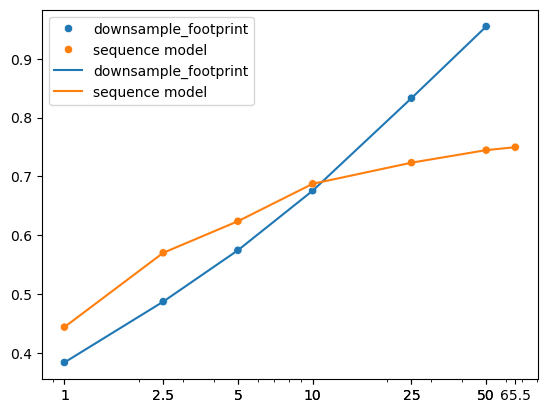

In [40]:
sns.scatterplot(x=x, y=score, hue=hue)
ax=sns.lineplot(x=x, y=score, hue=hue)
plt.xscale("log")
ax.set_xticks(x,x)
plt.savefig('/data/rzhang/PRINT_rev/HepG2/downsample_pearsonr.pdf')

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


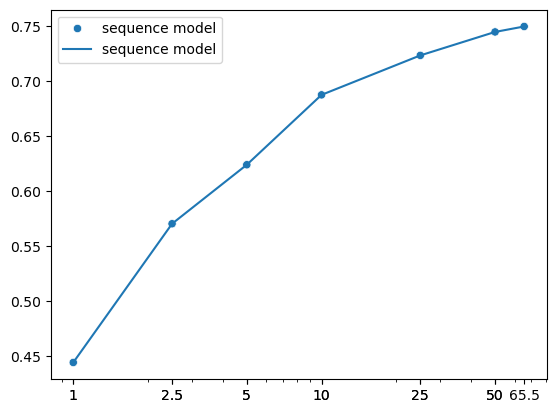

In [41]:
sns.scatterplot(x=x[6:], y=score[6:], hue=hue[6:])
ax=sns.lineplot(x=x[6:], y=score[6:], hue=hue[6:])
plt.xscale("log")
ax.set_xticks(x,x)
plt.savefig('/data/rzhang/PRINT_rev/HepG2/downsample_pearsonr_wo_baseline.pdf')

In [148]:
# Pick an example
chr, start, end = 'chr4', 39181938, 39182738
center = (start + end) // 2
pad = 920
seq = scp.genome.hg38.fetch_seq(chr, 
                                   center-pad, 
                                   center+pad)
seq = scp.utils.DNA_one_hot(seq).float().cuda()[None]

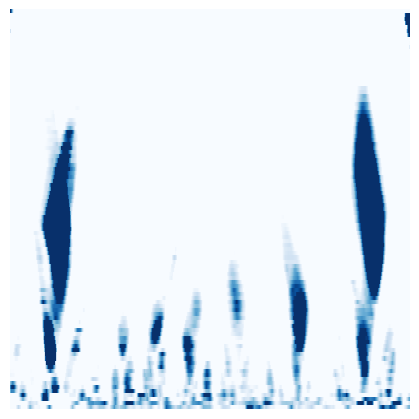

In [155]:
scp.pl.plot_footprints(printer_dict['HepG2'],
                       save_key=None,
                       group_names='HepG2',
                       cell_grouping=[printer_dict['HepG2'].insertion_file.obs_names],
                       region=f'{chr}:{start-100}-{end+100}',
                      clean_mode=True)
plt.savefig(f'/data/rzhang/PRINT_rev/HepG2/gt-{chr}:{start}-{end}.png', dpi=300)

In [127]:
pred_footprint_downsample = {}
for name in model_name:    
    tp = 0
    for model in model_name[name]:
        model = torch.load(model, map_location='cpu').cuda()
        tp += model(seq)[0][0].detach().cpu().numpy()
    tp /= len(model_name[name])
    pred_footprint_downsample[name] = tp

In [139]:
for name in pred_footprint_downsample:
    plt.figure()
    xx = scp.utils.zscore2pval(pred_footprint_downsample[name])
    sns.heatmap(xx[::-1], cmap='Blues', vmin=0, vmax=np.quantile(xx, 0.95), cbar=False)
    plt.axis('off')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(f'/data/rzhang/PRINT_rev/HepG2/{name}-{chr}:{start}-{end}.png', dpi=300)
    plt.close('all')

In [168]:
from scprinter.sync_visualization import _bigwig_footprint
scp.sync_visualization.set_global_var(printer_dict['HepG2'])

In [179]:
frag

'/data/rzhang/PRINT_rev/K562/all.frags.filt.tsv.gz'

In [180]:
frag_num_list = [50000000, 25000000, 10000000, 5000000, 2500000, 1000000]
for frag_num in frag_num_list:
    insertion = pyBigWig.open(f'/data/rzhang/PRINT_rev/HepG2/HepG2_{frag_num}.bw', 'rb')
    bias = pyBigWig.open('/home/rzhang/.cache/scprinter/hg38Tn5Bias.tar.gz.untar/hg38Tn5Bias.bw', 'rb')
    v = _bigwig_footprint(insertion, bias, chr, start, end, pad=100, extra=None, return_pval=True, smoothRadius=5)
    sns.heatmap(v[::-1],cmap='Blues', vmin=0, vmax=2.0, cbar=False)
    plt.axis('off')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(f'/data/rzhang/PRINT_rev/HepG2/gt_{frag_num}-{chr}:{start}-{end}.png', dpi=300)
    plt.close('all')